In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
epoch_key = "bon", 3, 2

In [4]:
animal, day, epoch = epoch_key
data_type, dim = "clusterless", "1D"

In [5]:
from src.load_data import load_data

data = load_data(epoch_key)

Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /data2/edeno/replay_trajectory_paper/src/../Raw-Data/Bond/bonDIO03.mat
No DIO file found, inferring correct inbound/outbound from task rules


In [6]:
import pandas as pd


def shuffle_run_position(position_info):
    n_time = position_info.shape[0]
    shuffled_position = pd.Series(np.full((n_time,), np.nan), index=position_info.index)

    for segment, df in position_info.groupby("labeled_segments"):
        n_segment_time = df.shape[0]
        if (segment == 0) | (n_segment_time == 1):
            shift = 0
        elif n_segment_time == 2:
            shift = np.random.randint(low=0, high=2)
        else:
            midpoint = (n_segment_time - 1) // 2
            shift = np.random.randint(low=-1 * midpoint, high=midpoint)

        shuffled_position.loc[df.index] = np.roll(df.linear_position, shift=shift)

    return shuffled_position

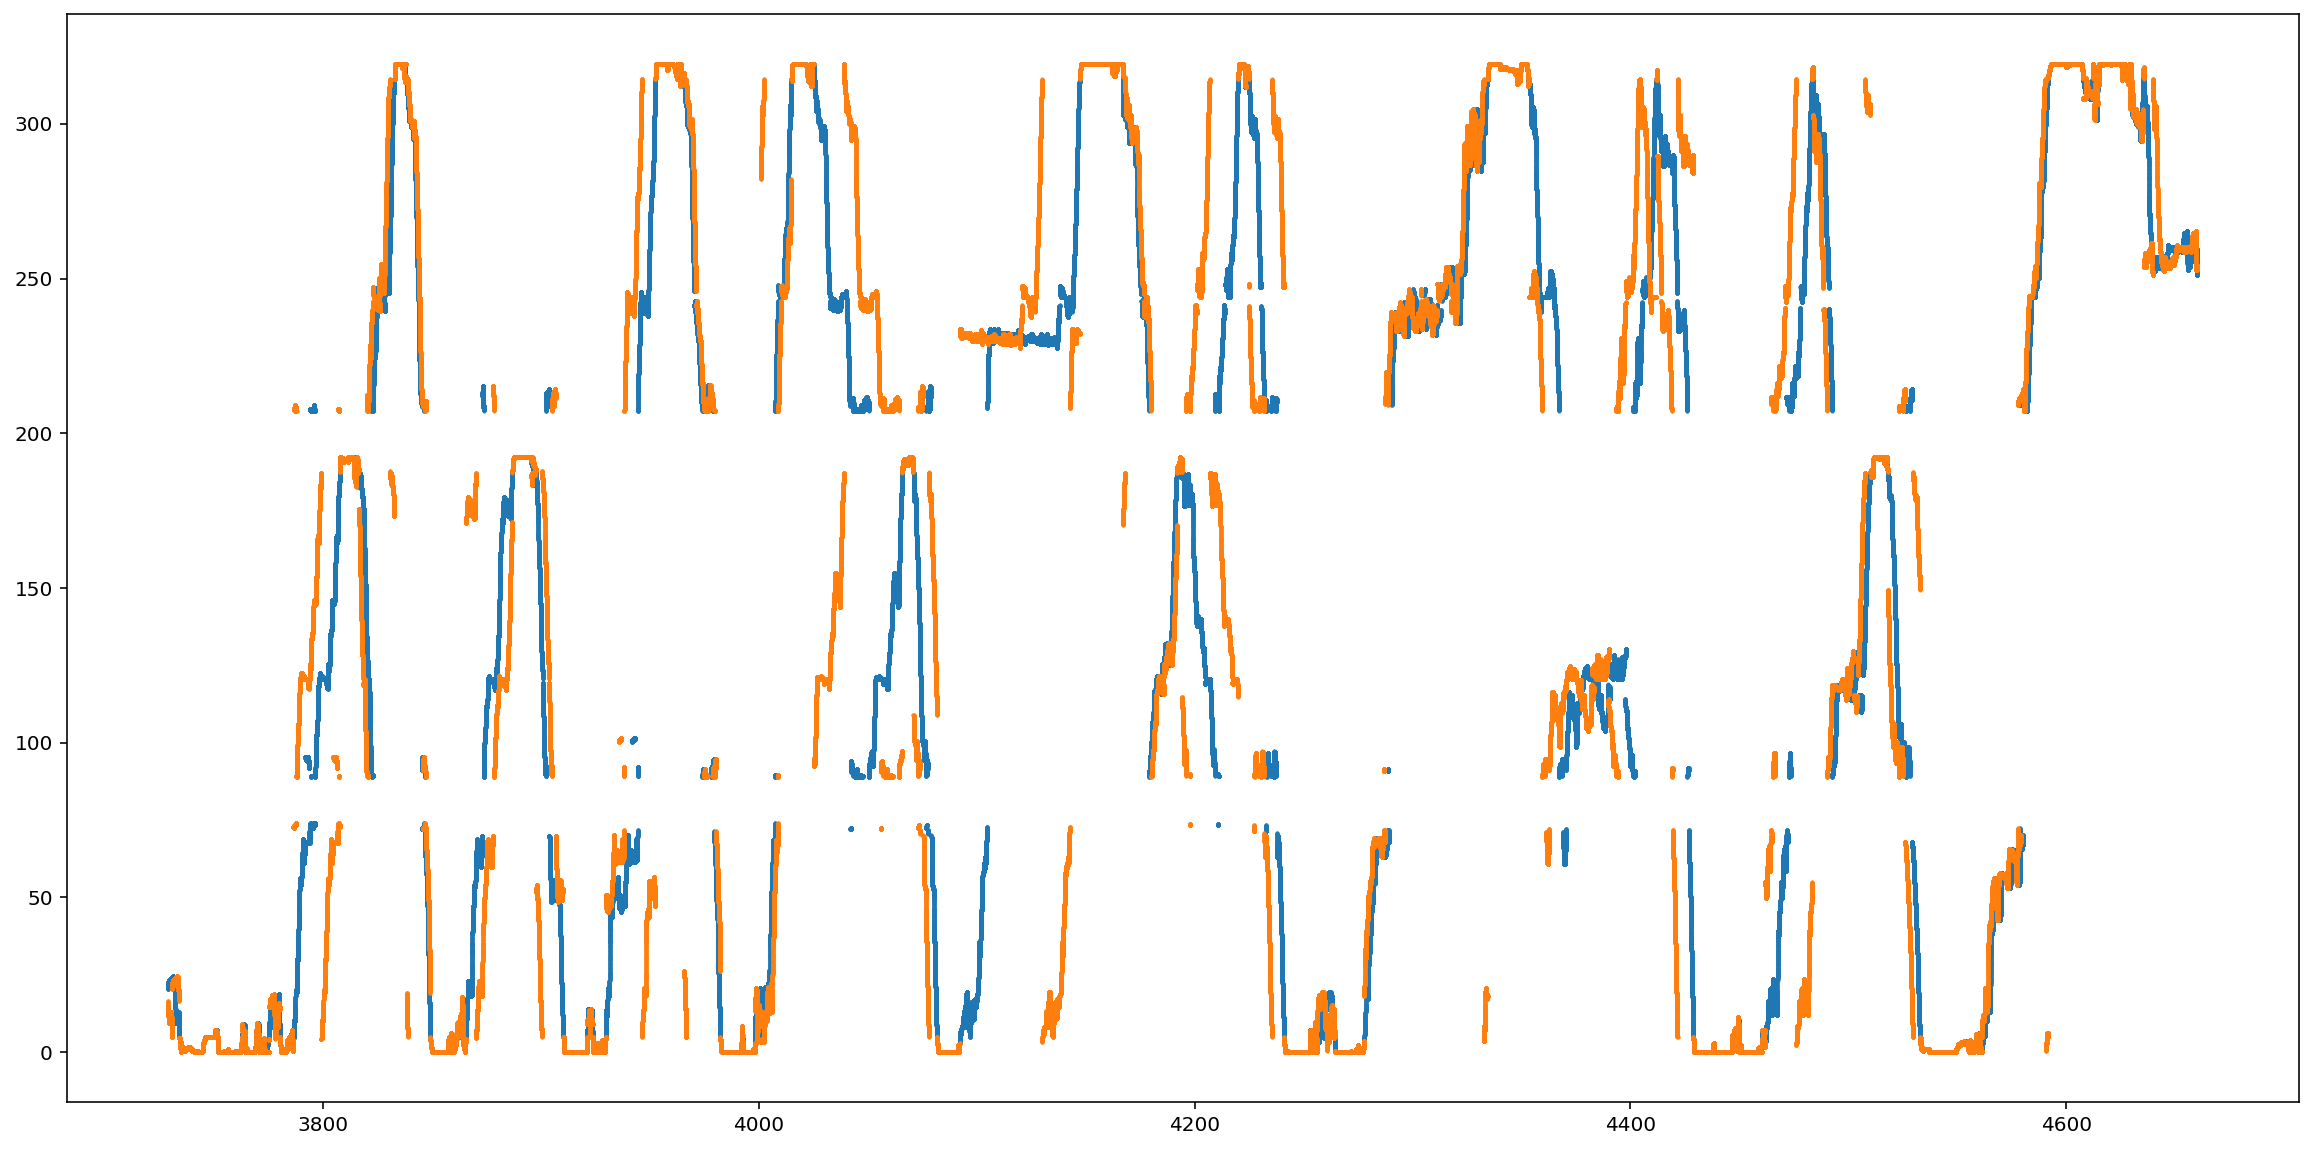

In [7]:
from loren_frank_data_processing.position import make_track_graph
from loren_frank_data_processing.position import EDGE_ORDER, EDGE_SPACING
from src.parameters import ANIMALS

is_training = data["position_info"].speed > 4
position = shuffle_run_position(data["position_info"])
track_labels = data["position_info"].arm_name
track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)

plt.figure(figsize=(20, 10))

plt.scatter(
    data["position_info"].index / np.timedelta64(1, "s"),
    data["position_info"].linear_position,
    s=1,
)
plt.scatter(data["position_info"].index / np.timedelta64(1, "s"), position, s=1)

In [8]:
import logging
import os
import sys
from argparse import ArgumentParser
from signal import SIGUSR1, SIGUSR2, signal
from subprocess import PIPE, run

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from dask.distributed import Client
from loren_frank_data_processing import save_xarray
from loren_frank_data_processing.position import make_track_graph
from replay_trajectory_classification import (
    ClusterlessClassifier,
    SortedSpikesClassifier,
)
from scipy.ndimage import label
from tqdm.auto import tqdm

from src.analysis import (
    get_linear_position_order,
    get_place_field_max,
    get_replay_info,
    reshape_to_segments,
)
from src.load_data import load_data
from src.parameters import (
    ANIMALS,
    FIGURE_DIR,
    PROBABILITY_THRESHOLD,
    PROCESSED_DATA_DIR,
    SAMPLING_FREQUENCY,
    TRANSITION_TO_CATEGORY,
    continuous_transition_types,
    discrete_diag,
    knot_spacing,
    model,
    model_kwargs,
    movement_var,
    place_bin_size,
    replay_speed,
    spike_model_penalty,
)
from src.visualization import (
    plot_category_counts,
    plot_category_duration,
    plot_neuron_place_field_2D_1D_position,
    plot_ripple_decode_1D,
    plot_ripple_decode_2D,
)

FORMAT = "%(asctime)s %(message)s"

logging.basicConfig(level="INFO", format=FORMAT, datefmt="%d-%b-%y %H:%M:%S")


def classify(
    classifier, data, edge_order, edge_spacing, epoch_key, name="actual",
):
    is_training = data["position_info"].speed > 4
    position = shuffle_run_position(data["position_info"])
    track_labels = data["position_info"].arm_name
    track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)

    animal, day, epoch = epoch_key
    data_type, dim = "clusterless", "1D"

    classifier.fit(
        position,
        data["multiunit"],
        is_training=is_training,
        track_graph=track_graph,
        center_well_id=center_well_id,
        edge_order=edge_order,
        edge_spacing=edge_spacing,
    )

    # Decode
    is_test = ~is_training

    test_groups = pd.DataFrame(
        {"test_groups": label(is_test.values)[0]}, index=is_test.index
    )
    immobility_results = []
    for _, df in tqdm(
        test_groups.loc[is_test].groupby("test_groups"), desc="immobility"
    ):
        start_time, end_time = df.iloc[0].name, df.iloc[-1].name
        test_multiunit = data["multiunit"].sel(time=slice(start_time, end_time))
        immobility_results.append(
            classifier.predict(test_multiunit, time=test_multiunit.time)
        )

    immobility_results = xr.concat(immobility_results, dim="time")

    results = [
        (
            immobility_results.sel(
                time=slice(df.start_time, df.end_time)
            ).assign_coords(time=lambda ds: ds.time - ds.time[0])
        )
        for _, df in data["ripple_times"].iterrows()
    ]

    results = xr.concat(results, dim=data["ripple_times"].index).assign_coords(
        state=lambda ds: ds.state.to_index().map(TRANSITION_TO_CATEGORY)
    )

    logging.info("Saving results...")
    #     save_xarray(
    #         os.path.join(PROCESSED_DATA_DIR, "run_position_shuffle"),
    #         epoch_key,
    #         results.drop(["causal_posterior"]),
    #         group=f"/{data_type}/{dim}/classifier/run_position_shuffle/{name}",
    #     )

    logging.info("Calculating replay_info...")
    ripple_times = data["ripple_times"].loc[:, ["start_time", "end_time"]]
    spikes = (
        ((data["multiunit"].sum("features") > 0) * 1.0)
        .to_dataframe(name="spikes")
        .unstack()
    )
    spikes.columns = data["tetrode_info"].tetrode_id
    ripple_spikes = reshape_to_segments(spikes, ripple_times)
    track_graph, _ = make_track_graph(epoch_key, ANIMALS)
    replay_info = get_replay_info(
        results,
        spikes,
        data["ripple_times"],
        data["position_info"],
        track_graph,
        SAMPLING_FREQUENCY,
        PROBABILITY_THRESHOLD,
        epoch_key,
        classifier,
        data["ripple_consensus_trace_zscore"],
    )

    logging.info("Saving replay_info...")
    epoch_identifier = f"{animal}_{day:02d}_{epoch:02d}_{data_type}_{dim}"
    os.makedir(os.path.join(PROCESSED_DATA_DIR, "run_position_shuffle"), exist_ok=True)
    replay_info_filename = os.path.join(
        PROCESSED_DATA_DIR,
        "run_position_shuffle",
        f"{epoch_identifier}_replay_info_{name}.csv",
    )
    replay_info.to_csv(replay_info_filename)

In [9]:
classifier = ClusterlessClassifier(
    place_bin_size=place_bin_size,
    movement_var=movement_var,
    replay_speed=replay_speed,
    discrete_transition_diag=discrete_diag,
    continuous_transition_types=continuous_transition_types,
    model=model,
    model_kwargs=model_kwargs,
)

classifier

ClusterlessClassifier(discrete_transition_diag=0.98, movement_var=6.0,
                      occupancy_kwargs={'bandwidth': array([24., 24., 24., 24.,  6.,  6.])},
                      occupancy_model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                      place_bin_size=3.0, replay_speed=1)

In [ ]:
for shuffle_ind in range(0, 25):
    classify(
        classifier,
        data,
        EDGE_ORDER,
        EDGE_SPACING,
        epoch_key,
        name=f"run_position_shuffle_{shuffle_ind:02d}",
    )

26-Jan-21 15:46:43 Fitting initial conditions...
26-Jan-21 15:46:44 Fitting state transition...
26-Jan-21 15:46:44 Fitting multiunits...


In [11]:
%debug

> <ipython-input-8-eec5f68dcdbf>(144)classify()
    142     logging.info("Saving replay_info...")
    143     epoch_identifier = f"{animal}_{day:02d}_{epoch:02d}_{data_type}_{dim}"
--> 144     os.makedir(os.path.join(PROCESSED_DATA_DIR, "run_position_shuffle"), exist_ok=True)
    145     replay_info_filename = os.path.join(
    146         PROCESSED_DATA_DIR,



ipdb>  q
